In [1]:
#Load Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
#load Dataset
dataset=pd.read_csv('./wireless_churn.csv')
dataset.head()

,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins,Churn
0,128,1,1,2.7,1,265.1,110,89.0,9.87,10.0,0
1,107,1,1,3.7,1,161.6,123,82.0,9.78,13.7,0
2,137,1,0,0.0,0,243.4,114,52.0,6.06,12.2,0
3,84,0,0,0.0,2,299.4,71,57.0,3.10,6.6,0
4,75,0,0,0.0,3,166.7,113,41.0,7.42,10.1,0


In [3]:
#dataset Info
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   AccountWeeks     3333 non-null   int64  
 1   ContractRenewal  3333 non-null   int64  
 2   DataPlan         3333 non-null   int64  
 3   DataUsage        3333 non-null   float64
 4   CustServCalls    3333 non-null   int64  
 5   DayMins          3333 non-null   float64
 6   DayCalls         3333 non-null   int64  
 7   MonthlyCharge    3333 non-null   float64
 8   OverageFee       3333 non-null   float64
 9   RoamMins         3333 non-null   float64
 10  Churn            3333 non-null   int64  
dtypes: float64(5), int64(6)
memory usage: 286.6 KB


In [4]:
# Create Profile Report

# Importing package
import pandas_profiling as pp
from IPython.display import IFrame

# Profile Report
FinalReport = pp.ProfileReport(dataset)
FinalReport.to_file('ReportFinalChurn-W24.html')
display(IFrame('ReportFinalChurn-W24.html', width=900, height=350))

C:\Users\rehal\AppData\Local\Temp\ipykernel_21156\2213907279.py:4: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling as pp


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
#create x and y varibales
x= dataset.drop('Churn', axis =1).to_numpy()
Y= dataset['Churn'].to_numpy()

#load library for training
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test =train_test_split(x,Y,test_size = 0.2,stratify=Y, random_state = 100)

#use built in isolation forest
from sklearn.ensemble import IsolationForest

#the prediction returns 1 if sample point is inlier. If outlier prediction returns -1
clf_all_features = IsolationForest(random_state=100)
clf_all_features.fit(x_train)

y_pred_train =clf_all_features.predict(x_train)
y_pred_train2 =np.array(list(map(lambda x: x == 1, y_pred_train)))

x_train_mod = x_train[y_pred_train2,  ]
y_train_mod = y_train[y_pred_train2,  ]

print('Original train Dataset Size : {}'.format(len(x_train)))
print('New Train Dataset Size      : {}'.format(len(x_train_mod)))


Original train Dataset Size : 2666
New Train Dataset Size      : 2124


In [6]:
#Scale the Data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train2 = sc.fit_transform(x_train_mod)
x_test2 = sc.fit_transform(x_test)

x_2 = sc.transform(x)

In [7]:
#prepare models
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB


In [8]:
#Construct some pipelines
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

#Create Pipeline
pipeline = []

pipe_logreg = Pipeline([('scl', StandardScaler()),
                        ('clf', LogisticRegression(solver='lbfgs', class_weight='balanced', max_iter=1000, random_state=100))])
pipeline.insert(0, pipe_logreg)

pipe_gnb = Pipeline([('scl', StandardScaler()),
                     ('clf', GaussianNB())])
pipeline.insert(1, pipe_gnb)

# Set grid search params
modelpara = []

param_gridlogreg = {'clf__C': [0.01, 0.1, 1, 10, 100],
                    'clf__penalty': ['l2']}
modelpara.insert(0, param_gridlogreg)

param_gridgnb = {}
modelpara.insert(1, param_gridgnb)

In [9]:
from sklearn.model_selection import learning_curve

def plot_learning_curves(model):
    train_sizes, train_scores, test_scores = learning_curve(estimator=model,
                                                            X=x_train_mod,
                                                            y=y_train_mod,
                                                            train_sizes=np.linspace(0.1, 1.0, 10),
                                                            cv=10,
                                                            scoring='recall_weighted',
                                                            random_state=100)

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5,
             label='training accuracy')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std,
                     alpha=0.15, color='blue')

    plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5,
             label='validation accuracy')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std,
                     alpha=0.15, color='green')

    plt.grid(True)
    plt.xlabel('Number of training samples')
    plt.ylabel('Recall')
    plt.legend(loc='lower right')
    plt.ylim([0.5, 1.01])
    plt.show()

Logistic Regression Learning Curves


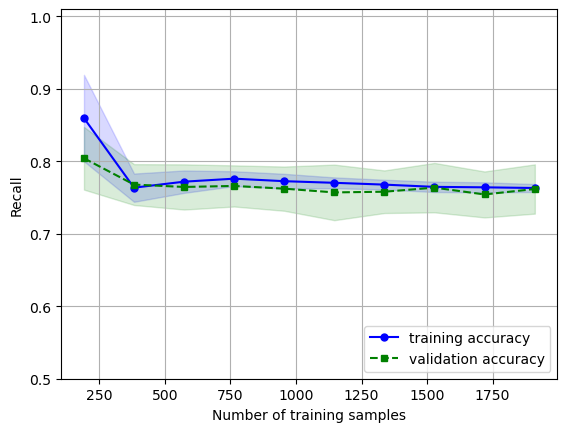


 GNB Leaning Curve


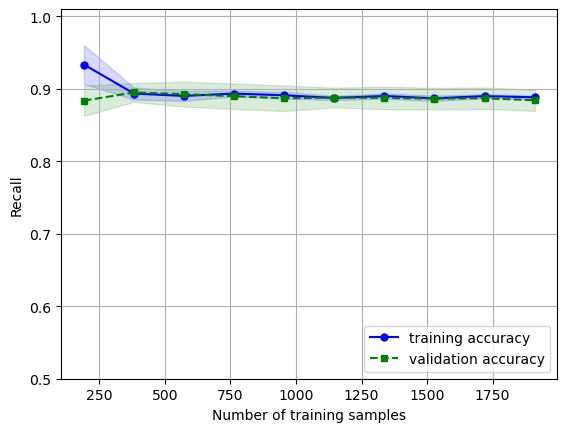

In [10]:
# learning Curve
print('Logistic Regression Learning Curves')
plot_learning_curves(pipe_logreg)
print('\n GNB Leaning Curve')
plot_learning_curves(pipe_gnb)

Model Evaluation - Recall Score
Logistic Regression: 0.761383 (0.027085)


GNB: 0.886513 (0.020762)


Bagging Classifier: 0.936245 (0.015952)


AdaBoost: 0.911668 (0.022197)


GBC: 0.937466 (0.017292)




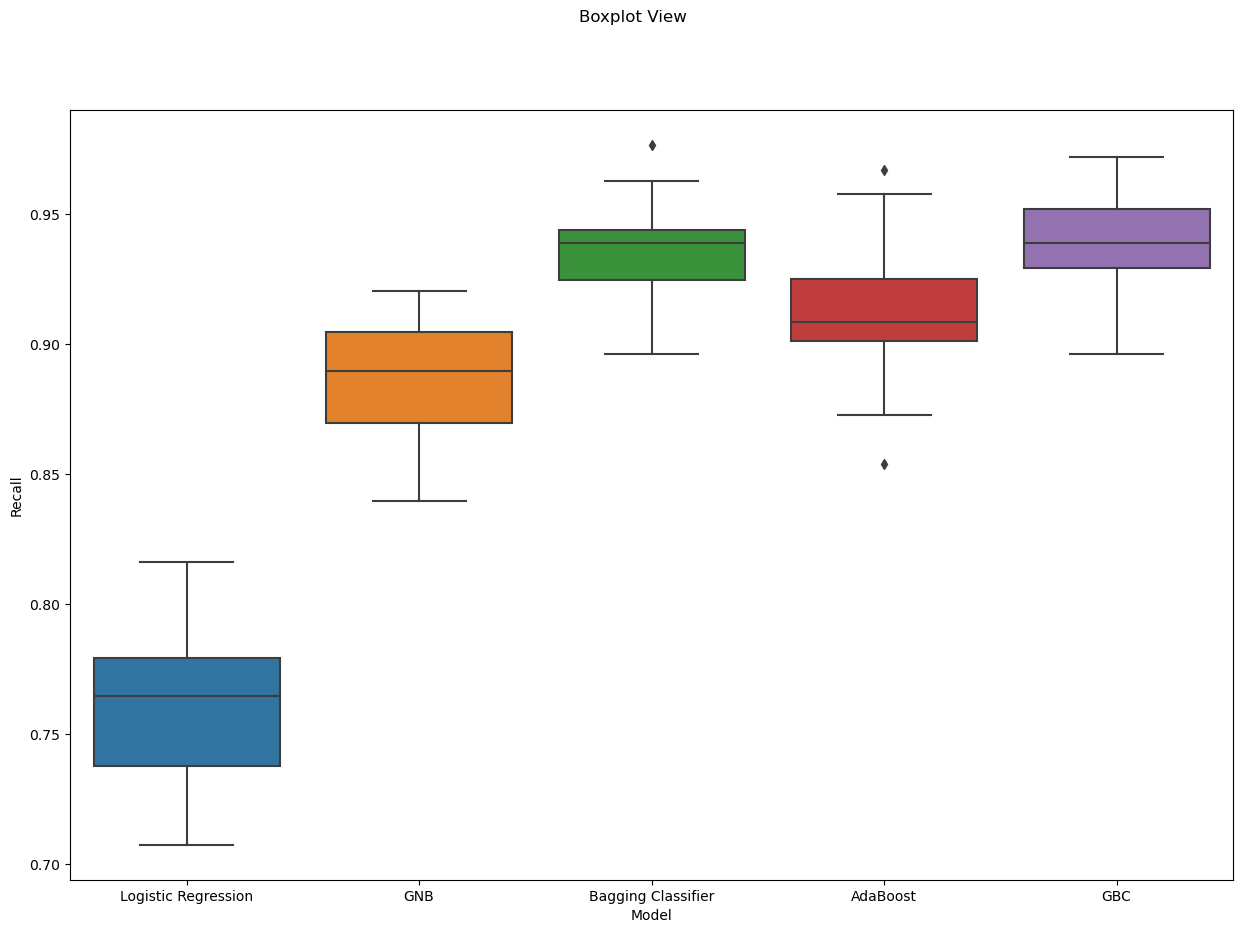

In [11]:
##Model Analysis
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

modelAnalysis=[]

modelAnalysis.append(('Logistic Regression', LogisticRegression(solver='lbfgs', class_weight='balanced', max_iter=1000, random_state=100)))

modelAnalysis.append(('GNB', GaussianNB()))

modelAnalysis.append(('Bagging Classifier', BaggingClassifier(random_state=100)))

modelAnalysis.append(('AdaBoost', AdaBoostClassifier(random_state=100)))

modelAnalysis.append(('GBC', GradientBoostingClassifier(random_state=100)))

##Model Evaluation
results = []
names = []
scoring = 'recall_weighted'
print('Model Evaluation - Recall Score')
for name, model in modelAnalysis:
    kfold = RepeatedKFold(n_splits=10, n_repeats=5, random_state=100)
    cv_results = cross_val_score(model, x_train2, y_train_mod, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
    print('\n')

#Boxplot View
fig = plt.figure(figsize=(15,10))
fig.suptitle('Boxplot View')
ax = fig.add_subplot(111)
sns.boxplot(data=results)
ax.set_xticklabels(names)
plt.ylabel('Recall')
plt.xlabel('Model')
plt.show()

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

def Gridsearch_cv(model, params):
    # Cross-validation Function
    cv2=RepeatedKFold(n_splits=10, n_repeats=5, random_state=108)
    
    # GridSearch CV
    gs_clf = GridSearchCV(model, params, cv = cv2, scoring='recall_weighted')
    gs_clf = gs_clf.fit(x_train_mod, y_train_mod)
    model = gs_clf.best_estimator_
    
    # Use best model and test data for final evaluation
    y_pred = model.predict(x_test2)
    
    # Identify Best Parameters to Optimize the Model
    bestparams=str(gs_clf.best_params_)
    
    # Output Heading
    print('Optimized Model!')
    print('Model Name: ' + str(pipeline.named_steps['clf']))
    
    # Output Validation Statistics
    print('\n', confusion_matrix(y_test,y_pred))
    print('\n', classification_report(y_test,y_pred))
    print('\n')

    # Transform the variables into binary (0,1) - ROC Curve

    from sklearn import preprocessing 
    Forecast1=pd.DataFrame(y_pred)
    Outcome1=pd.DataFrame(y_test)
    lb1 = preprocessing.LabelBinarizer()
    OutcomeB1 = lb1.fit_transform(Outcome1)
    ForecastB1 = lb1.fit_transform(Forecast1)
    #Setup the ROC Curve
    from sklearn.metrics import roc_curve, auc
    from sklearn import metrics
    fpr, tpr, threshold = metrics.roc_curve(OutcomeB1, ForecastB1)
    roc_auc = metrics.auc(fpr, tpr)
    print('ROC Curve')
   
    #Plot the ROC Curve
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


    

Optimized Model!
Model Name: LogisticRegression(class_weight='balanced', max_iter=1000, random_state=100)

 [[535  35]
 [ 75  22]]

               precision    recall  f1-score   support

           0       0.88      0.94      0.91       570
           1       0.39      0.23      0.29        97

    accuracy                           0.84       667
   macro avg       0.63      0.58      0.60       667
weighted avg       0.81      0.84      0.82       667



ROC Curve


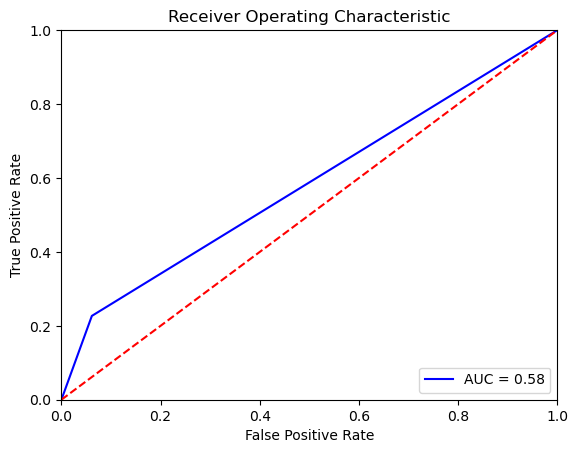

Optimized Model!
Model Name: GaussianNB()

 [[185 385]
 [  9  88]]

               precision    recall  f1-score   support

           0       0.95      0.32      0.48       570
           1       0.19      0.91      0.31        97

    accuracy                           0.41       667
   macro avg       0.57      0.62      0.40       667
weighted avg       0.84      0.41      0.46       667



ROC Curve


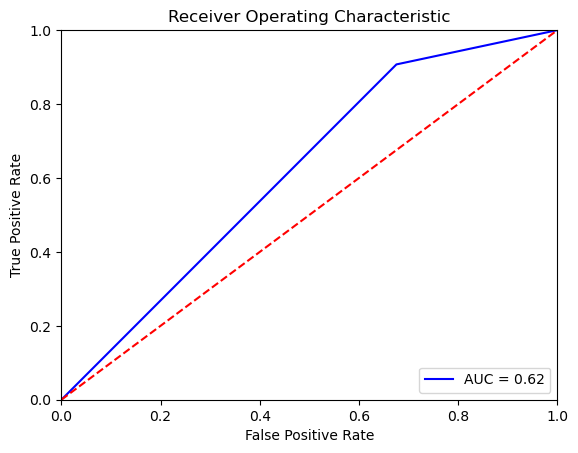

In [13]:
#run model
for pipeline, modelpara in zip(pipeline,modelpara):
    Gridsearch_cv(pipeline,modelpara)
    

In [14]:
# Create Voting Model v1
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_validate

estimators = []

model1 = GaussianNB()
estimators.append(('GNB', model1))

model2 = AdaBoostClassifier(random_state=100)
estimators.append(('AdaBoost', model2))

voting_clf = VotingClassifier(estimators, voting='soft')

scoring = {'acc': 'accuracy',
           'prec_macro': 'precision_macro',
           'rec_macro': 'recall_macro'}

for clf in (model1, model2, voting_clf):
    rkfcv = clf.fit(x_train2, y_train_mod)
    ens_rkf = RepeatedKFold(n_splits=10, n_repeats=5, random_state=100)
    rKFcv = cross_validate(rkfcv, x_2, Y, scoring=scoring, cv=ens_rkf)
    print(clf.__class__.__name__, round(rKFcv['test_rec_macro'].mean(), 2))



GaussianNB 0.67
AdaBoostClassifier 0.71
VotingClassifier 0.67


In [15]:
#Create Voting Model v2
estimators2 = []

model11 = LogisticRegression(solver='lbfgs', class_weight='balanced', max_iter=1000, random_state=100)
estimators2.append(('LogReg', model11))

model22 = AdaBoostClassifier(random_state=100)
estimators2.append(('AdaBoost', model22))

voting_clf2=VotingClassifier(estimators2, voting='soft')
scoring = {'acc': 'accuracy',
           'prec_macro': 'precision_macro',
           'rec_macro': 'recall_macro'}

for clf in (model11, model22, voting_clf2):
    rkfcv=clf.fit(x_train2,y_train_mod)
    ens_rkf1 = RepeatedKFold(n_splits=10, n_repeats=5, random_state=100)
    rKFcv = cross_validate(rkfcv, x_2, Y, scoring=scoring, cv=ens_rkf1)
    print(clf.__class__.__name__, round(rKFcv['test_rec_macro'].mean(),2))

LogisticRegression 0.76
AdaBoostClassifier 0.71
VotingClassifier 0.76
